In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2

from settings import MNIST_SETTINGS
from model import construct_PPNet
from save import load_model_from_train_state
from helpers import find_high_activation_crop

from datasets.mnist_dataset import MnistBags

In [3]:
device = torch.device('cuda')

In [4]:
config = MNIST_SETTINGS

In [5]:
# load_model_dir = './saved_models/mnist.plaster.2021-03-03T16:04:24.365208'
# load_model_dir = './saved_models/mnist.szarancza.2021-03-16T22:02:39.855973'# 100
load_model_dir = './saved_models/mnist.szarancza.2021-03-16T21:03:32.479013'# 50

load_model_name = '40.push.best.122.89.90.pck'

load_model_path = os.path.join(load_model_dir, load_model_name)

ppnet = construct_PPNet(base_architecture=config.base_architecture,
                        pretrained=False, 
                        img_size=config.img_size,
                        prototype_shape=config.prototype_shape,
                        num_classes=config.num_classes,
                        prototype_activation_function=config.prototype_activation_function,
                        add_on_layers_type=config.add_on_layers_type,
                        batch_norm_features=config.batch_norm_features)

print('load model from ' + load_model_path)
load_model_from_train_state(load_model_path, ppnet)

ppnet = ppnet.to(device)

load model from ./saved_models/mnist.szarancza.2021-03-16T21:03:32.479013/40.push.best.122.89.90.pck


In [6]:
# confirm prototype class identity
epoch_number_str = re.search(r'\d+', load_model_name).group(0)
load_img_dir = os.path.join(load_model_dir, 'img')

prototype_info = np.load(os.path.join(load_img_dir, 'epoch-'+epoch_number_str, 'bb'+epoch_number_str+'.npy'))
prototype_img_identity = prototype_info[:, -1]

print('Prototypes are chosen from ' + str(len(set(prototype_img_identity))) + ' number of classes.')
print('Their class identities are: ' + str(prototype_img_identity))

Prototypes are chosen from 2 number of classes.
Their class identities are: [0 0 0 0 0 0 0 1 1 1 1 1 1 1]


In [7]:
ds_test = MnistBags(train=False, bag_length_mean=50, bag_length_std=2, positive_samples_in_bag_ratio_mean=0.1, positive_samples_in_bag_ratio_std=0.02)

test_loader = torch.utils.data.DataLoader(
    ds_test, batch_size=None, 
    shuffle=True,
    num_workers=0,
    pin_memory=False)

In [8]:
it = iter(test_loader)

In [13]:
bag, label = next(it)
bag = bag.squeeze(0)

In [14]:
label

tensor([1])

In [15]:
len(bag)

50

In [16]:
with torch.no_grad():
    ppnet.eval()
    
    images_test = bag.to(device)
    labels_test = label.to(device)

    logits, min_distances, attention, vector_scores = ppnet(images_test) # function forward in model.py should return logits, min_distances, A, prototype_activations

    conv_output, distances = ppnet.push_forward(images_test)
    prototype_activations = ppnet.distance_2_similarity(min_distances)
    prototype_activation_patterns = ppnet.distance_2_similarity(distances)
    if ppnet.prototype_activation_function == 'linear':
        prototype_activations = prototype_activations + max_dist
        prototype_activation_patterns = prototype_activation_patterns + max_dist

    tables = []
    for i in range(logits.size(0)):
        tables.append((torch.argmax(logits, dim=1)[i].item(), labels_test[i].item()))
        # print(str(i) + ' ' + str(tables[-1]))

    idx = 0
    predicted_cls = tables[idx][0]
    correct_cls = tables[idx][1]    
    print('Predicted: ' + str(predicted_cls))
    print('Actual: ' + str(correct_cls))

Predicted: 1
Actual: 1


### Take the N patches with the most attention

In [17]:
N = 10
at = attention.squeeze(0).detach().cpu().numpy()
top_patches = at.argsort()[-N:][::-1]
print(f'patch indexes: {top_patches}')

patch indexes: [37 16 48 32  8 28 49 42 14 15]


In [18]:
imgs = [bag[i].permute(1, 2, 0) for i in top_patches]

### Take the most highly activated area of the image by prototype

In [19]:
imgs_with_self_activation_by_prototype = []
for img, idx in zip(imgs, top_patches):
    original_img = img

    self_activation_for_img = []
    # for every prototype
    for i in range(len(prototype_img_identity)):
        activation_pattern = prototype_activation_patterns[idx][i].detach().cpu().numpy()
        upsampled_activation_pattern = cv2.resize(activation_pattern, dsize=(28, 28),
                                                    interpolation=cv2.INTER_CUBIC)

        # show the most highly activated patch of the image by this prototype
        high_act_patch_indices = find_high_activation_crop(upsampled_activation_pattern)
        high_act_patch = original_img[high_act_patch_indices[0]:high_act_patch_indices[1],
                                        high_act_patch_indices[2]:high_act_patch_indices[3], :]

        rescaled_activation_pattern = upsampled_activation_pattern - np.amin(upsampled_activation_pattern)
        rescaled_activation_pattern = rescaled_activation_pattern / np.amax(rescaled_activation_pattern)
        heatmap = cv2.applyColorMap(np.uint8(255*rescaled_activation_pattern), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        heatmap = heatmap[...,::-1]
        overlayed_img = 0.5 * original_img + 0.3 * heatmap

        self_activation_for_img.append(np.asarray(overlayed_img))
    
    imgs_with_self_activation_by_prototype.append(np.asarray(self_activation_for_img))

In [20]:
np.asarray(imgs_with_self_activation_by_prototype).shape

(10, 14, 28, 28, 3)

### Take prototypes

In [21]:
prototype_dir = os.path.join(load_img_dir, 'epoch-'+epoch_number_str)

In [22]:
prototypes = []
for i in range(len(prototype_img_identity)):
    prototypes.append(plt.imread(f'{prototype_dir}/prototype-img{i}.png'))

### Take prototypes img original with self activation

In [23]:
prototypes_img_with_act = []
for i in range(len(prototype_img_identity)):
    prototypes_img_with_act.append(plt.imread(f'{prototype_dir}/prototype-img-original_with_self_act{i}.png'))

### Find the k-nearest patches in the dataset to each prototype

In [24]:
import find_nearest
from helpers import makedir

k = 5

ppnet = torch.nn.DataParallel(ppnet)

ds_train = MnistBags(train=True)

train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=None, 
    shuffle=True,
    num_workers=0,
    pin_memory=False)

root_dir_for_saving_train_images = os.path.join(load_model_dir,                                                load_model_name.split('.pth')[0] + '_nearest_train')
if not os.path.exists(root_dir_for_saving_train_images):
    makedir(root_dir_for_saving_train_images)

    find_nearest.find_k_nearest_patches_to_prototypes(
        dataloader=train_loader,  # pytorch dataloader (must be unnormalized in [0,1])
        prototype_network_parallel=ppnet,  # pytorch network with prototype_vectors
        k=k,
        preprocess_input_function=None,  # normalize if needed
        full_save=True,
        root_dir_for_saving_images=root_dir_for_saving_train_images,
        log=print)

In [25]:
k_nearest_patches = []

for i in range(len(prototype_img_identity)):
    tmp = []
    for j in range(1, k+1):
        tmp.append(plt.imread(f'{root_dir_for_saving_train_images}/{i}/nearest-{j}_original_with_heatmap.png'))
    k_nearest_patches.append(np.asarray(tmp))


In [26]:
np.asarray(k_nearest_patches).shape

(14, 5, 28, 28, 4)

###  Vector score for top patches

In [27]:
arr = vector_scores.detach().cpu().numpy()
arr = np.array([arr[i] for i in top_patches])
arr.shape

(10, 14)

In [28]:
def get_colors(inp, colormap, vmin=None, vmax=None):
    norm = plt.Normalize(vmin, vmax)
    return colormap(norm(inp))

In [29]:
grid_score = np.around(arr.T, 2)

In [30]:
colors = get_colors(grid_score, plt.cm.magma)

In [31]:
colors.shape

(14, 10, 4)

In [32]:
len_proto = len(prototype_img_identity)

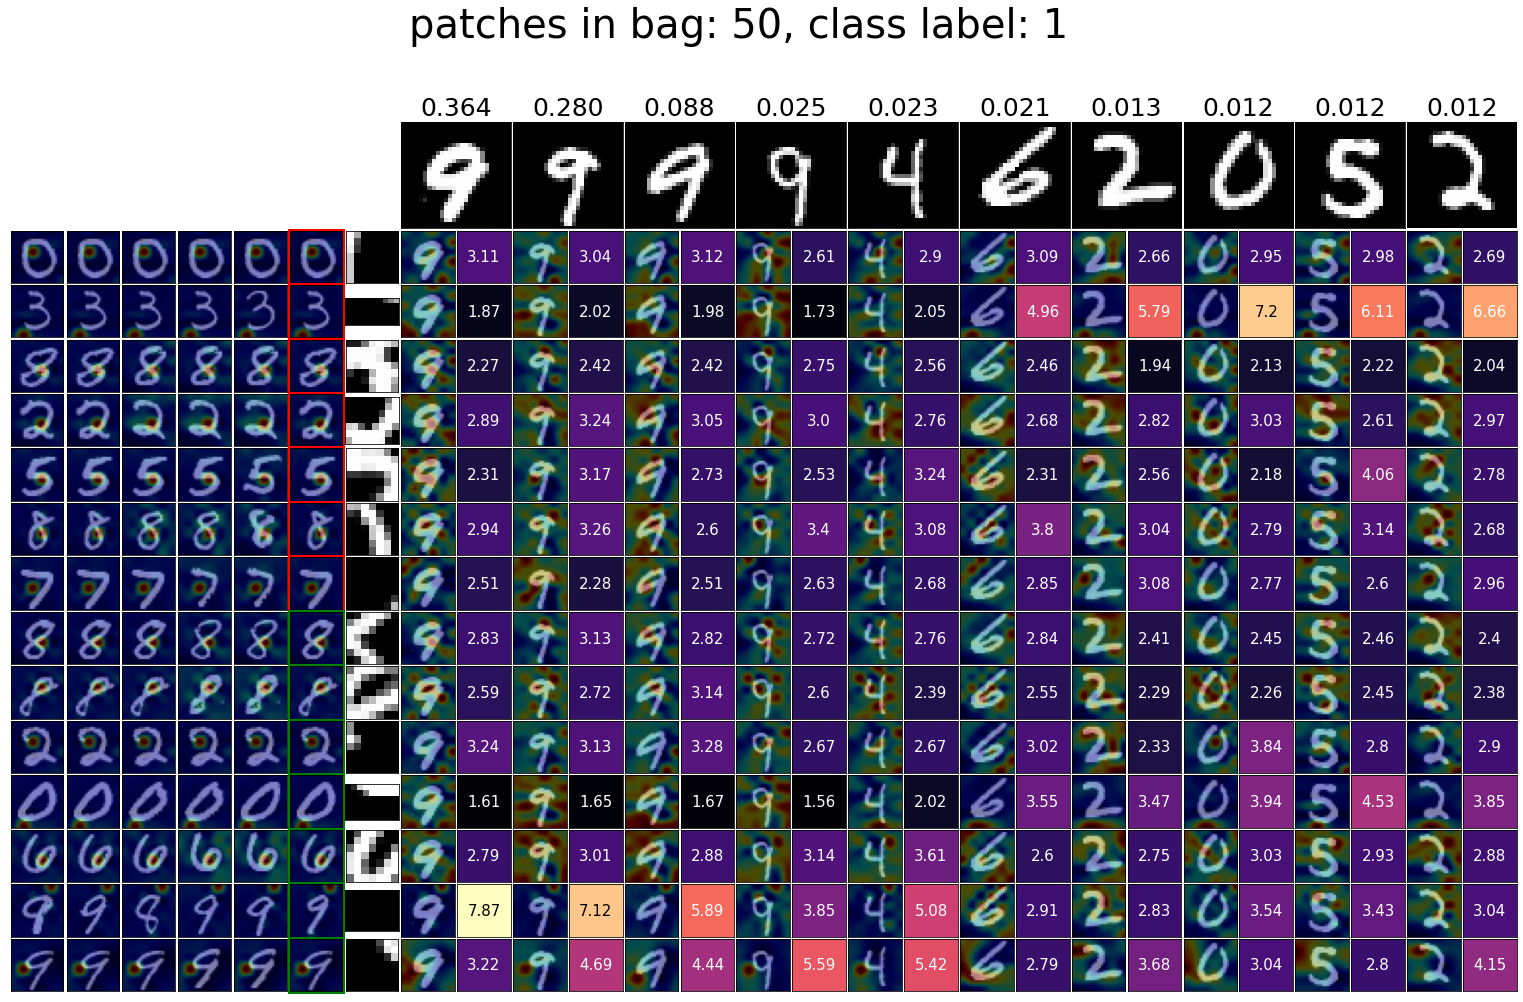

In [33]:
# Set up the axes with gridspec
fig = plt.figure(figsize=(2*N+2+k, len_proto+2))
fig.suptitle(f'patches in bag: {len(bag)}, class label: {label.item()}', fontsize=40)

grid = plt.GridSpec(len_proto+2, 2*N+2+k, hspace=0.04, wspace=0.04)

# build a rectangle in axes coords
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

# histogram
l = 0
for j in range(3+k, 2*N+3+k, 2):
    for i in range(2, len_proto+2):
        main_ax = fig.add_subplot(grid[i, j])
        main_ax.set_facecolor(colors[i-2][l])
        main_ax.text(0.5*(left+right), 0.5*(bottom+top), grid_score[i-2][l],
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=15, 
            color='white' if grid_score[i-2][l] < grid_score.max() * 0.9 else 'black',
            transform=main_ax.transAxes)

        main_ax.get_xaxis().set_visible(False)
        main_ax.get_yaxis().set_visible(False)
    l = l + 1

# images with self activation by prototype
l = 0
for j in range(2+k, 2*N+2+k, 2):
    for i in range(2, len_proto+2):
        main_ax = fig.add_subplot(grid[i, j])
        main_ax.set_xlim([0, 27])
        main_ax.set_ylim([0, 27])
        main_ax.invert_yaxis()
        main_ax.imshow(imgs_with_self_activation_by_prototype[l][i-2], aspect='auto')

        main_ax.get_xaxis().set_visible(False)
        main_ax.get_yaxis().set_visible(False)
    l = l + 1

# prototypes
for i in range(2, len_proto+2):
    main_ax = fig.add_subplot(grid[i, 1+k])
    main_ax.invert_yaxis()
    main_ax.imshow(prototypes[i-2])
    
    main_ax.get_xaxis().set_visible(False)
    main_ax.get_yaxis().set_visible(False)

# prototypes images with activation
for i in range(2, len_proto+2):
    main_ax = fig.add_subplot(grid[i, 0+k])
    main_ax.set_xlim([0, 27])
    main_ax.set_ylim([0, 27])
    main_ax.invert_yaxis()
    main_ax.imshow(prototypes_img_with_act[i-2])

    if i-2 < len_proto // 2:
        main_ax.patch.set_edgecolor('red')
    else:
        main_ax.patch.set_edgecolor('green')
    main_ax.patch.set_linewidth('5')  
    
    main_ax.get_xaxis().set_visible(False)
    main_ax.get_yaxis().set_visible(False)

# k nearest patches
for j in range(k):
    for i in range(2, len_proto+2):
        main_ax = fig.add_subplot(grid[i, j])
        main_ax.set_xlim([0, 27])
        main_ax.set_ylim([0, 27])
        main_ax.invert_yaxis()
        main_ax.imshow(k_nearest_patches[i-2][j])
        
        main_ax.get_xaxis().set_visible(False)
        main_ax.get_yaxis().set_visible(False)

# patches
l = 0
for i in range(2+k, 2*N+2+k, 2):
    main_ax = fig.add_subplot(grid[0:2, i:i+2])
    main_ax.set_xlim([0, 27])
    main_ax.set_ylim([0, 27])
    main_ax.invert_yaxis()
    main_ax.set_title(f'{at[top_patches[l]]:.3f}', fontsize=25)
    main_ax.imshow(imgs[l], aspect='auto')

    main_ax.get_xaxis().set_visible(False)
    main_ax.get_yaxis().set_visible(False)
    l = l + 1

plt.axis('off')
plt.show()